Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dataset=pd.read_csv('Binance_BTCUSDT_minute.csv')
# Convert date column to datetime
dataset['date'] = pd.to_datetime(dataset['date'], format='%d-%m-%Y %H.%M')


# Display the first few rows
print("Data Overview:")
print(dataset.head())

print("\nData Information:")
print(dataset.info())
# Statistical Summary
print("\nStatistical Summary:")
print(dataset.describe())


Data Overview:
           unix                date    symbol      open      high       low  \
0  1.660000e+12 2022-07-27 08:43:00  BTC/USDT  21374.96  21383.02  21371.20   
1  1.660000e+12 2022-07-27 08:42:00  BTC/USDT  21365.39  21376.76  21360.00   
2  1.660000e+12 2022-07-27 08:41:00  BTC/USDT  21368.87  21383.24  21361.66   
3  1.660000e+12 2022-07-27 08:40:00  BTC/USDT  21376.72  21383.59  21365.00   
4  1.660000e+12 2022-07-27 08:39:00  BTC/USDT  21400.48  21404.94  21370.60   

      close  Volume BTC   Volume USDT  tradecount  
0  21379.57    19.00999  4.063805e+05         947  
1  21373.64    58.41095  1.248064e+06        2452  
2  21366.17    93.96567  2.008269e+06        3034  
3  21368.06    79.80295  1.705508e+06        2654  
4  21374.88   124.52471  2.662596e+06        3215  

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048574 entries, 0 to 1048573
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------    

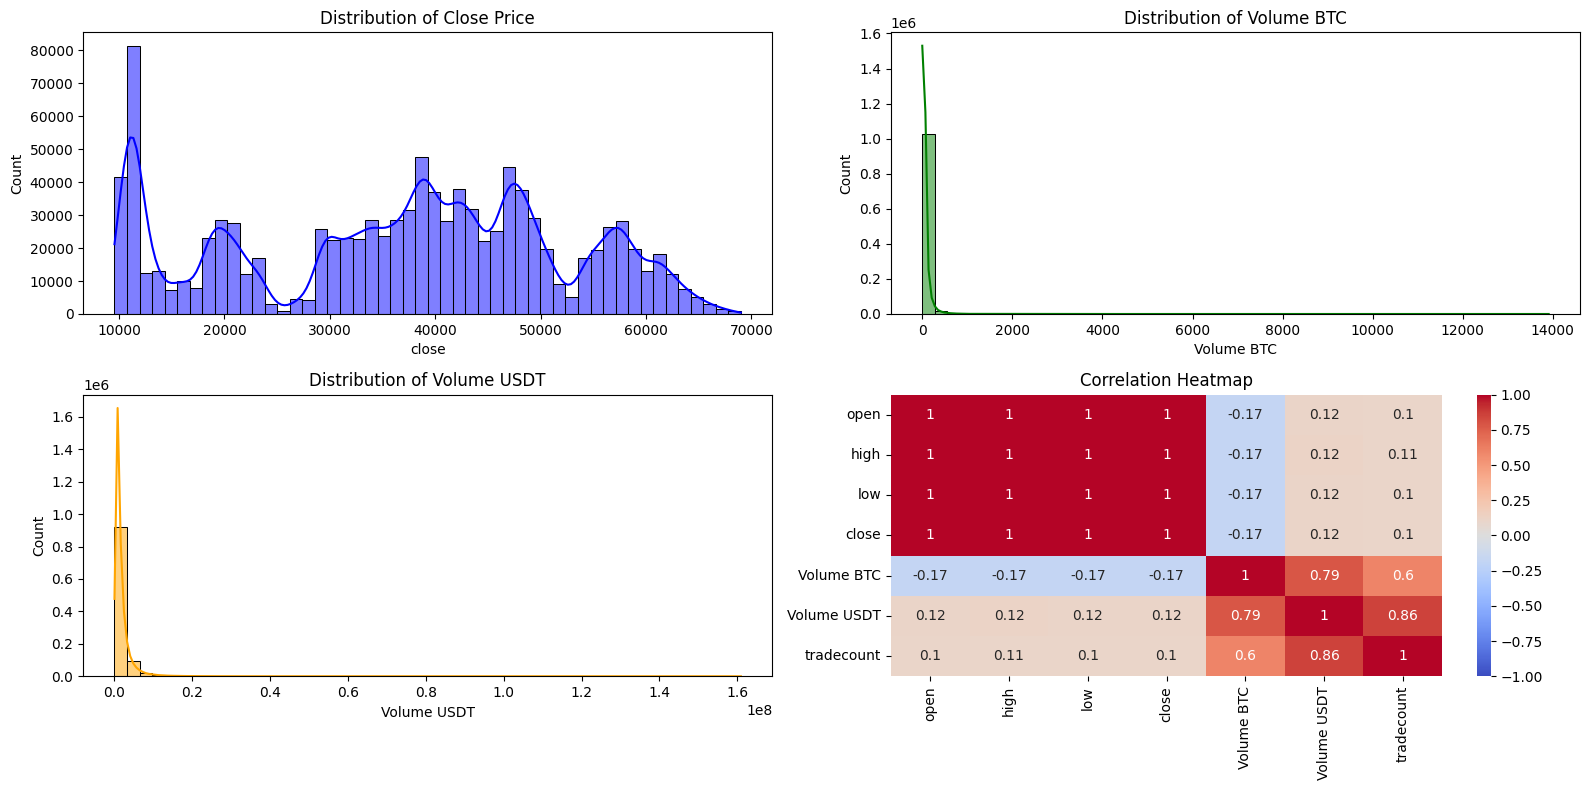

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure for multiple plots
plt.figure(figsize=(16, 8))

# Distribution of the 'close' price
plt.subplot(2, 2, 1)
sns.histplot(dataset['close'], kde=True, bins=50, color='blue')
plt.title('Distribution of Close Price')

# Distribution of the 'Volume BTC'
plt.subplot(2, 2, 2)
sns.histplot(dataset['Volume BTC'], kde=True, bins=50, color='green')
plt.title('Distribution of Volume BTC')

# Distribution of the 'Volume USDT'
plt.subplot(2, 2, 3)
sns.histplot(dataset['Volume USDT'], kde=True, bins=50, color='orange')
plt.title('Distribution of Volume USDT')

# Correlation heatmap
plt.subplot(2, 2, 4)
columns_of_interest = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USDT', 'tradecount']
corr = dataset[columns_of_interest].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()


Spark Session

In [1]:
import pandas as pd
import pandas_ta as ta
import talib
import mplfinance as mpf
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import sum as spark_sum
from pyspark.ml.feature import VectorAssembler, StandardScaler
from datetime import timedelta
from pyspark.sql.types import DoubleType
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
from pyspark.ml import Pipeline



spark = SparkSession.builder.appName("CryptoDataAnalysisMachine").master("local[4]").getOrCreate()


# Load data

df = spark.read.csv("BTC_BUY_SELL.csv", header=True, inferSchema=True)
df.na.drop()
# Convert date to timestamp

df = df.withColumn("date_with_colon", regexp_replace(col("date"), r"\.", ":")) \
      .withColumn("timestamp", to_timestamp(col("date_with_colon"), "dd-MM-yyyy H:mm"))

# Drop original date column
df = df.drop("date")
df.drop("date_with_colon")
df=df.limit(10000)
df=df.orderBy('timestamp')
df_original=df
'''
df_agg = df.groupBy(window(df.timestamp), "1 hour")\
    .agg(
    first("timestamp").alias("timestamp"),
    first("open").alias("open"),
    max("high").alias("high"),
    min("low").alias("low"),
    last("close").alias("close")
    ).orderBy('timestamp').select("timestamp", "open", "high", "low", "close")

df_agg.show()
'''
df.show(n=1000,truncate=False)


+-------+--------+--------+--------+--------+--------+----------+-------------+----------+------+----+-------------+-----------------+-----------------+-----+----------------+-------------------+
|unix   |symbol  |open    |high    |low     |close   |Volume BTC|Volume USDT  |tradecount|hammer|doji|shooting_star|bullish_engulfing|bearish_engulfing|trend|date_with_colon |timestamp          |
+-------+--------+--------+--------+--------+--------+----------+-------------+----------+------+----+-------------+-----------------+-----------------+-----+----------------+-------------------+
|1.66E12|BTC/USDT|23509.07|23529.97|23504.93|23527.69|45.72246  |1075165.043  |2250      |0     |0   |0            |0                |0                |0    |20-07-2022 10:04|2022-07-20 10:04:00|
|1.66E12|BTC/USDT|23527.69|23567.09|23525.03|23563.04|159.67213 |3760114.25   |4461      |0     |0   |0            |0                |0                |0    |20-07-2022 10:05|2022-07-20 10:05:00|
|1.66E12|BTC/USDT|23

Model Training

DataFrame[unix: double, symbol: string, open: double, high: double, low: double, close: double, Volume BTC: double, Volume USDT: double, tradecount: int, hammer: int, doji: int, shooting_star: int, bullish_engulfing: int, bearish_engulfing: int, trend: int, date_with_colon: string, timestamp: timestamp]
Mean Squared Error (MSE): 2846.8980088851326
Root Mean Squared Error (RMSE): 53.35633054179356
Mean Absolute Error (MAE): 33.37176764556511
R2: 0.9955207575239657
Cross-validated RMSE: 47.347877566833894
Cross-validated MAE: 25.762780120687268
Cross-validated R2: 0.9964727706787123


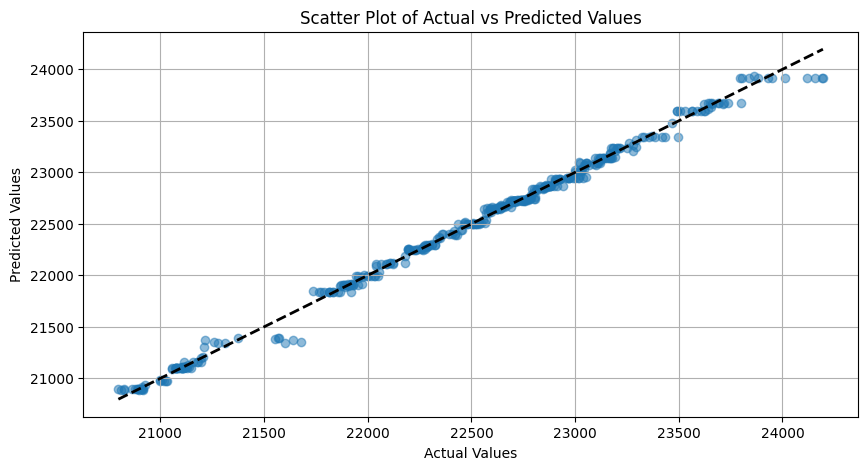

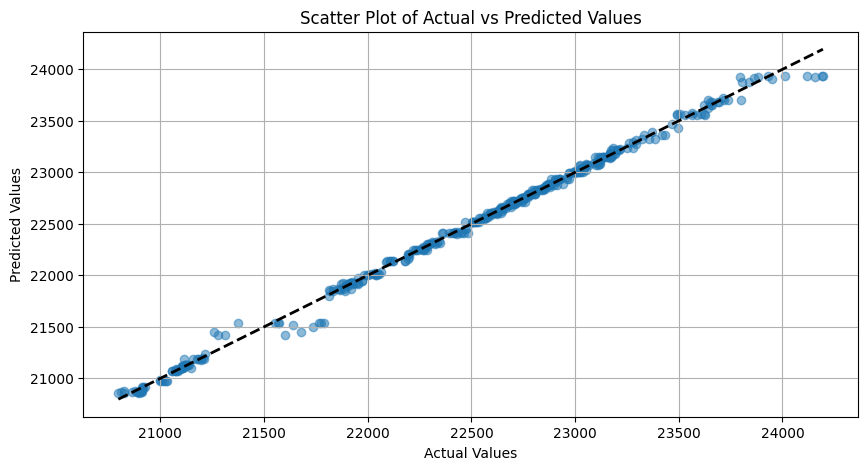

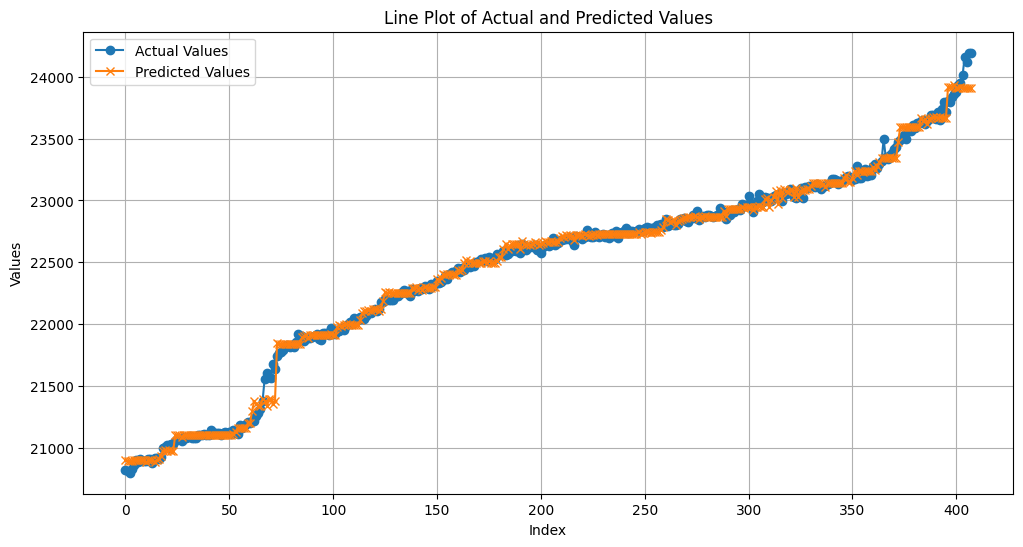

In [2]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

if 'assembled_features' in df.columns:
    df = df.drop('assembled_features')
print(df)
window_spec = Window.orderBy('timestamp')
# Calculate previous close price and next close price
df = df.withColumn('prev_close', lag('close', 1).over(window_spec))
df = df.withColumn('next_close', lag('close', -1).over(window_spec))
df = df.withColumn('prev_open', lag('open', 1).over(window_spec))
df = df.withColumn('prev_high', lag('high', 1).over(window_spec))
df = df.withColumn('prev_low', lag('low', 1).over(window_spec))

df = df.filter(
    (col('bullish_engulfing') == 1) |
    (col('bearish_engulfing') == 1) |
    (col('doji') == 1) |
    (col('hammer') == 1) |
    (col('shooting_star') == 1)
)
# Define features and labels
feature_columns = [
    'open', 'high', 'low', 'close',  # OHLCV data
    'bullish_engulfing', 'bearish_engulfing', 'doji', 'hammer', 'shooting_star',  # Pattern indicators
    'trend'  # Trend column already encoded as 0 and 1
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol='assembled_features',handleInvalid='skip')

df = df.withColumn('label', col('next_close'))

# Define the label and create a column for it

# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
# Initialize RandomForestRegressor
rf = RandomForestRegressor(featuresCol='assembled_features', labelCol='label', numTrees=100)

# Create and run the pipeline
pipeline = Pipeline(stages=[assembler, rf])

model = pipeline.fit(train_data)


# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse')
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Show predictions
#predictions.select("label", "prediction").show(n=2000,truncate=False)

evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2: {r2}")
# Define a parameter grid for hyperparameter tuning
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 150])  # Example: number of trees in RandomForest
             .addGrid(rf.maxDepth, [5, 10, 15])    # Example: maximum depth of trees
             .build())

# Define the cross-validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_rmse,
                          numFolds=5,  # Number of folds for cross-validation
                          seed=42)

# Run cross-validation
cv_model = crossval.fit(df)

# Extract the best model from cross-validation
best_model = cv_model.bestModel

# Make predictions using the best model
cv_predictions = best_model.transform(test_data)

# Evaluate the best model
cv_rmse = evaluator_rmse.evaluate(cv_predictions)
cv_mae = evaluator_mae.evaluate(cv_predictions)
cv_r2 = evaluator_r2.evaluate(cv_predictions)

print(f"Cross-validated RMSE: {cv_rmse}")
print(f"Cross-validated MAE: {cv_mae}")
print(f"Cross-validated R2: {cv_r2}")
pandas_df=predictions.toPandas()
# Scatter Plot
plt.figure(figsize=(10, 5))
plt.scatter(pandas_df['label'], pandas_df['prediction'], alpha=0.5)
plt.plot([pandas_df['label'].min(), pandas_df['label'].max()], [pandas_df['label'].min(), pandas_df['label'].max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.grid(True)
plt.show()
cv_pandas_df=cv_predictions.toPandas()
plt.figure(figsize=(10, 5))
plt.scatter(cv_pandas_df['label'], cv_pandas_df['prediction'], alpha=0.5)
plt.plot([cv_pandas_df['label'].min(), cv_pandas_df['label'].max()], [cv_pandas_df['label'].min(), cv_pandas_df['label'].max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.grid(True)
plt.show()


# Line Plot
plt.figure(figsize=(12, 6))
plt.plot(pandas_df.index, pandas_df['label'], label='Actual Values', marker='o')
plt.plot(pandas_df.index, pandas_df['prediction'], label='Predicted Values', marker='x')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Line Plot of Actual and Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


Predication Evaluation

In [3]:
cv_predictions = cv_predictions.withColumn('pattern', 
    when(col('bullish_engulfing') == 1, 'Bullish Engulfing')
    .when(col('bearish_engulfing') == 1, 'Bearish Engulfing')
    .when(col('hammer') == 1, 'Hammer')
    .when(col('shooting_star') == 1, 'Shooting Star')
    .when(col('doji') == 1, 'Doji')
    .otherwise('No Pattern'))

# Generate signals based on patterns, trends, and predictions
cv_predictions = cv_predictions.withColumn('signal',
    when((col('bullish_engulfing') == 1)&(col('prediction') > col('prev_close')), 1)
    .when((col('bearish_engulfing') == 1)&(col('prediction') < col('prev_close')), 2)
    .when((col('hammer') == 1)&(col('prediction') > col('prev_close')), 1)
    .when((col('shooting_star') == 1)&(col('prediction') < col('prev_close')), 2)
    .when((col('doji') == 1) & (col('trend') == 1) & (col('prediction') > col('prev_close')), 1)  # Doji example for Buy
    .when((col('doji') == 1) & (col('trend') == 0) & (col('prediction') < col('prev_close')), 2) # Doji example for Sell
    .otherwise(0))
cv_predictions.show()

+-------+--------+--------+--------+--------+--------+----------+-----------+----------+------+----+-------------+-----------------+-----------------+-----+----------------+-------------------+----------+----------+---------+---------+--------+--------+--------------------+------------------+-----------------+------+
|   unix|  symbol|    open|    high|     low|   close|Volume BTC|Volume USDT|tradecount|hammer|doji|shooting_star|bullish_engulfing|bearish_engulfing|trend| date_with_colon|          timestamp|prev_close|next_close|prev_open|prev_high|prev_low|   label|  assembled_features|        prediction|          pattern|signal|
+-------+--------+--------+--------+--------+--------+----------+-----------+----------+------+----+-------------+-----------------+-----------------+-----+----------------+-------------------+----------+----------+---------+---------+--------+--------+--------------------+------------------+-----------------+------+
|1.66E12|BTC/USDT|20783.55|20793.29|20770.1

Predicted Values Visualization

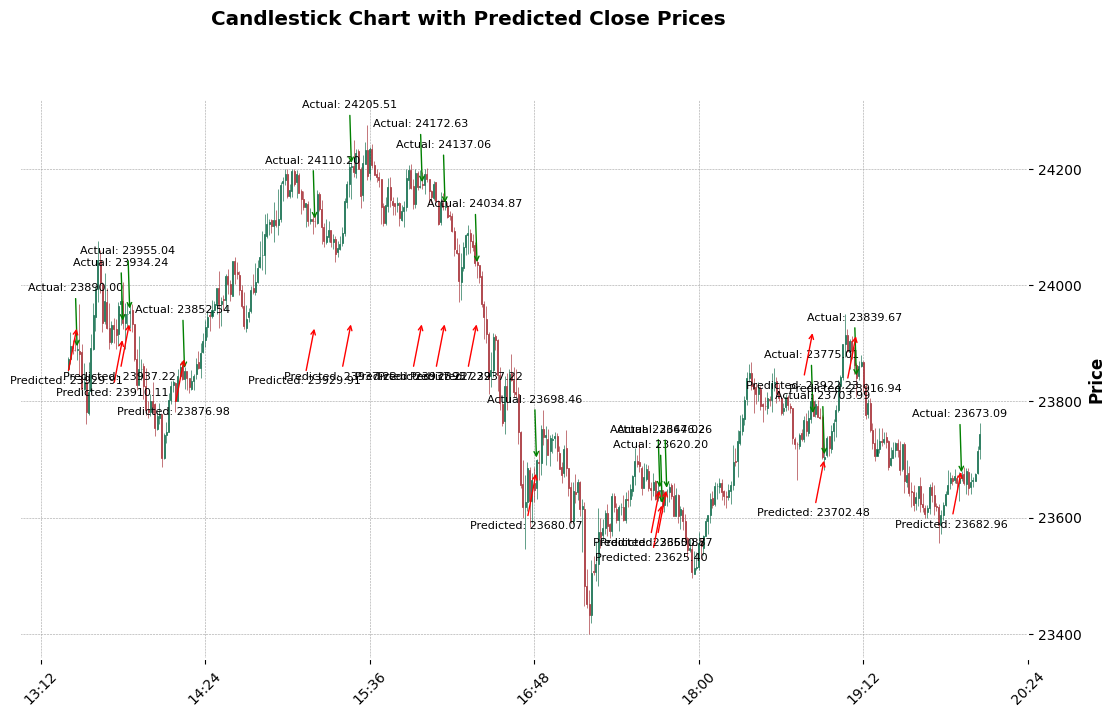

In [31]:
pd.set_option('display.max_rows', None)

cv_prediction_pandas=cv_predictions.toPandas()
cv_prediction_pandas['timestamp'] = cv_prediction_pandas['timestamp'].dt.strftime('%Y-%m-%d %H:%M')

# Set timestamp as index
cv_prediction_pandas.set_index('timestamp', inplace=True)



orignal_df_pandas=df_original.toPandas()
orignal_df_pandas['timestamp'] = orignal_df_pandas['timestamp'].dt.strftime('%Y-%m-%d %H:%M')

# Set timestamp as index
orignal_df_pandas.set_index('timestamp', inplace=True)


# Prepare OHLCV data
# Merge the original data with predictions to include buy signals
merged_df = orignal_df_pandas.merge(cv_prediction_pandas[['prediction']], left_index=True, right_index=True, how='left')

merged_df.index=pd.to_datetime(merged_df.index)
merged_df.fillna(0,inplace=True)
merged_df=merged_df[200:600]
#print(merged_df)

# Prepare the DataFrame in the format expected by mplfinance
plot_df = merged_df[['open', 'high', 'low', 'close']]
ohlcv = plot_df[['open', 'high', 'low', 'close']]
ohlcv.columns = ['open', 'high', 'low', 'close']
ohlcv.index = pd.to_datetime(plot_df.index)

# Plot the candlestick chart with buy signals
fig, axlist=mpf.plot(
    ohlcv,
    type='candle',
    style='charles',
    title='Candlestick Chart with Predicted Close Prices',
    ylabel='Price',
    figsize=(14,8),
    figscale=1.0,
    show_nontrading=True,
    returnfig=True
)

for index, row in merged_df.iterrows():
    if row['prediction']!=0:
    # Annotate actual close price
        axlist[0].annotate(
                f'Actual: {row["close"]:.2f}',
                xy=(index, row['close']),
                xytext=(index - pd.Timedelta(minutes=-20), row['close'] + 100),
                arrowprops=dict(color='green', arrowstyle='->'),
                fontsize=8,
                ha='right'
        )
    
    # Annotate predicted close price
    if row['prediction']!=0:
        axlist[0].annotate(
            f'Predicted: {row["prediction"]:.2f}',
            xy=(index, row['prediction']),
            xytext=(index - pd.Timedelta(minutes=-20), row['prediction'] - 100),
                arrowprops=dict(color='red', arrowstyle='->'),
            fontsize=8,
            ha='right'
        )

plt.show()



                             unix    symbol      open      high       low  \
timestamp                                                                   
2022-07-20 13:24:00  1.660000e+12  BTC/USDT  23856.40  23877.19  23844.15   
2022-07-20 13:25:00  1.660000e+12  BTC/USDT  23873.48  23919.67  23864.07   
2022-07-20 13:26:00  1.660000e+12  BTC/USDT  23895.04  23906.41  23881.00   
2022-07-20 13:27:00  1.660000e+12  BTC/USDT  23888.42  23909.90  23886.72   
2022-07-20 13:28:00  1.660000e+12  BTC/USDT  23887.91  23905.41  23871.01   
2022-07-20 13:29:00  1.660000e+12  BTC/USDT  23887.52  23968.00  23843.78   
2022-07-20 13:30:00  1.660000e+12  BTC/USDT  23885.49  23899.60  23821.26   
2022-07-20 13:31:00  1.660000e+12  BTC/USDT  23821.90  23865.69  23820.00   
2022-07-20 13:32:00  1.660000e+12  BTC/USDT  23833.33  23850.52  23761.36   
2022-07-20 13:33:00  1.660000e+12  BTC/USDT  23780.61  23867.39  23777.24   
2022-07-20 13:34:00  1.660000e+12  BTC/USDT  23817.62  23915.98  23815.54   

c:\Users\luvkumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


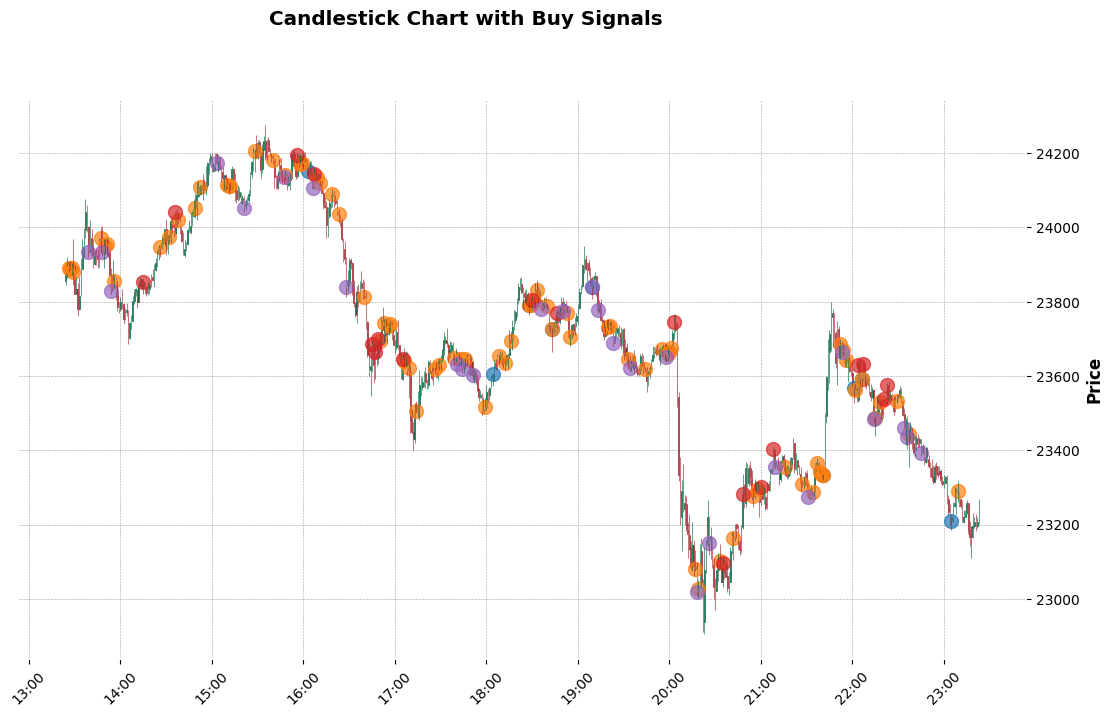

In [75]:
pd.set_option('display.max_rows', None)

buy_sell_signal_pandas=cv_predictions.toPandas()
buy_sell_signal_pandas['timestamp'] = buy_sell_signal_pandas['timestamp'].dt.strftime('%Y-%m-%d %H:%M')

# Set timestamp as index
buy_sell_signal_pandas.set_index('timestamp', inplace=True)



orignal_df_pandas=df_original.toPandas()
orignal_df_pandas['timestamp'] = orignal_df_pandas['timestamp'].dt.strftime('%Y-%m-%d %H:%M')

# Set timestamp as index
orignal_df_pandas.set_index('timestamp', inplace=True)


# Prepare OHLCV data
# Merge the original data with predictions to include buy signals
merged_df = orignal_df_pandas.merge(buy_sell_signal_pandas[['signal','pattern']], left_index=True, right_index=True, how='left')

# Ensure 'buy_signal' NaN values are treated as 0 (no signal)
merged_df['signal'].fillna(0, inplace=True)
merged_df['pattern'].fillna(0, inplace=True)

merged_df.index=pd.to_datetime(merged_df.index)
merged_df=merged_df[200:800]
print(merged_df)

# Prepare the DataFrame in the format expected by mplfinance
plot_df = merged_df[['open', 'high', 'low', 'close']]
ohlcv = plot_df[['open', 'high', 'low', 'close']]
ohlcv.columns = ['open', 'high', 'low', 'close']
ohlcv.index = pd.to_datetime(plot_df.index)

scatter_data = pd.DataFrame(index=merged_df.index)
scatter_data['buy_signal'] = np.nan
scatter_data['sell_signal'] = np.nan
scatter_data.loc[merged_df['signal']==1, 'buy_signal'] = merged_df.loc[merged_df['signal']==1, 'close']
scatter_data.loc[merged_df['signal']==2, 'sell_signal'] = merged_df.loc[merged_df['signal']==2, 'close']


# Plot the candlestick chart with buy signals
fig, axlist=mpf.plot(
    ohlcv,
    type='candle',
    style='charles',
    title='Candlestick Chart with Patterns',
    ylabel='Price',
    figsize=(14,8),
    figscale=1.0,
    show_nontrading=True,
    returnfig=True
)

patterns = ['hammer', 'doji', 'shooting_star','bullish_engulfing','bearish_engulfing']

for pattern in patterns:
    pattern_data = merged_df[merged_df[pattern] == 1]
    axlist[0].scatter(pattern_data.index, pattern_data['close'], label=pattern, marker='o', s=100, alpha=0.7)

# Adding titles, labels, and legends

plt.show()

